<a href="https://colab.research.google.com/github/TheQuanEnthusiast/MachineLearning/blob/main/Fruit_Predicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('/content/fruit.csv')

In [ ]:
data.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [ ]:
X = data.iloc[:, 3:]
y = data.iloc[:, 0]
print('Class labels: ', np.unique(y))

Class labels:  [1 2 3 4]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
#random_state is pseudo_random number generator that is used for shuffling when splitting
#stratify=y means that train_test_split returns the same proportions of class labels as input dataset
print('Labels counts in y: ', np.bincount(y))
print('Labels counts in y_train: ', np.bincount(y_train))
print('Labels counts in y_test : ', np.bincount(y_test))

Labels counts in y:  [ 0 19  5 19 16]
Labels counts in y_train:  [ 0 13  4 13 11]
Labels counts in y_test :  [0 6 1 6 5]


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train) #learns parameters from dataset
X_train_std = sc.transform(X_train) #transforms our data with the parameters it learned via fit method
X_test_std = sc.transform(X_test) #transforms our data with the parameters it learned via fit method


In [ ]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 5):
  mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
  print('MV %s: %s\n' % (label, mean_vecs[label-1]))

MV 1: [ 0.2114  0.5587 -0.2357  0.3024]

MV 2: [-1.7169 -1.5205 -2.289   0.4283]

MV 3: [0.3752 0.4223 0.1011 0.1125]

MV 4: [-0.0689 -0.6064  0.9914 -0.6462]



In [ ]:
d = 4 #number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 5), mean_vecs):
  class_scatter = np.zeros((d, d))
for row in X_train_std[y_train==label]:
  row, mv = row.reshape(d, 1), mv.reshape(d, 1)
  class_scatter+=(row-mv).dot((row-mv).T)
  S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))



Within-class scatter matrix: 4x4


In [ ]:
#One of the assumptions in LDA is that the class labels must be distributed uniformly. If we check that we see that
#this rule isn't followed
np.bincount(y_train)

array([ 0, 13,  4, 13, 11])

In [ ]:
#That's why we must scale our previous scatter-matrix by dividing number of class labels(4)
d = 4 #number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(1, 5), mean_vecs):
  class_scatter = np.zeros((d, d))
for row in X_train_std[y_train==label]:
  row, mv = row.reshape(d, 1), mv.reshape(d, 1)
  class_scatter+=((row-mv).dot((row-mv).T))
  S_W += class_scatter
print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))


Within-class scatter matrix: 4x4


In [ ]:
mean_overall = np.mean(X_train_std, axis=0)
d = 4 #number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
  n = X_train_std[y_train==i+1, :].shape[0]
  mean_vec = mean_vec.reshape(d, 1)
  mean_overall = mean_overall.reshape(d, 1)
  S_B += n*(mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Betwee-class scatter matrix: %sx%s: ' % (S_B.shape[0], S_B.shape[1]))

Betwee-class scatter matrix: 4x4: 


In [ ]:
#Let's calculate eigenpairs. Here we will use numpy's linalg module.
eigenvalues, eigenvectors = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [ ]:
#Let's sort the eigenvalues by descending order
eigenpairs = [(np.abs(eigenvalues[i]), eigenvectors[:, i]) for i in range(len(eigenvalues))]
eigenpairs = sorted(eigenpairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order: \n')
for eig_val in eigenpairs:
  print(eig_val[0])


Eigenvalues in descending order: 

19.795874485786218
0.41288820041647833
0.03852902469662671
1.021647613109338e-16


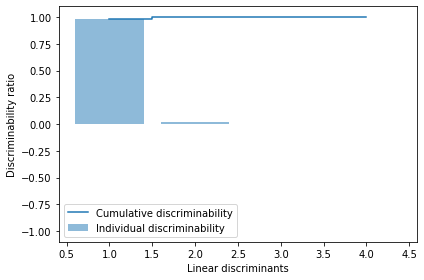

In [ ]:
#S_B is the sum of matrices that ranks one or less. Let's see how much class_discriminatory information is captured by the eigenvectors
import matplotlib.pyplot as plt
total = sum(eigenvalues.real)
discriminability = [(i/total) for i in sorted(eigenvalues.real, reverse=True)]
cumulative_discriminability = np.cumsum(discriminability)
plt.bar(range(1, 5), discriminability, alpha=0.5, align='center', label = 'Individual discriminability')
plt.step(range(1, 5), cumulative_discriminability, where='mid', label = 'Cumulative discriminability')
plt.ylabel('Discriminability ratio')
plt.xlabel('Linear discriminants')
plt.ylim(-1.1, 1.1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
#As we can see from the figure, first two linear discriminants almost capture 100% of the information. And we will stack them to formulate transformation matrix of W
W = np.hstack((eigenpairs[0][1][:, np.newaxis].real, eigenpairs[1][1][:, np.newaxis].real))
print('W matrix: \n', W)

W matrix: 
 [[-0.0386  0.5532]
 [ 0.1617  0.1178]
 [-0.2042  0.3703]
 [ 0.9647  0.7368]]


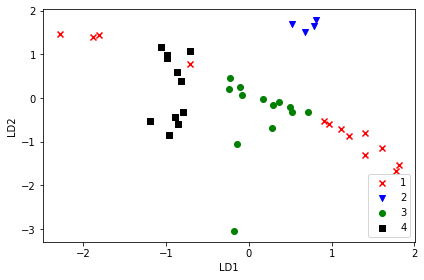

In [ ]:
#Now let's transform our training dataset by multiplying W and training dataset
X_train_lda = X_train_std.dot(W)
colors = ['r', 'b', 'g', 'k']
markers = ['x', 'v', 'o', 's']
for l, c, m in zip(np.unique(y_train), colors, markers):
  plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1]*(-1), c=c, label=l, marker=m)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
#Now let's implement LDA using scikit-learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [ ]:
#Now let's see how logistic regression classifier handles low-dimensional datsest after LDA transformation
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=50.0, random_state=1, solver='lbfgs', multi_class='ovr')
trained = lr.fit(X_train_lda, y_train)


In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^')
    colors = ('r', 'b', 'g', 'k')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
        alpha=0.8, c=colors[idx],
        marker=markers[idx], label=cl,
        edgecolor='black')
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
        c='', edgecolor='black', alpha=1.0,
        linewidth=1, marker='o',
        s=100, label='test set')

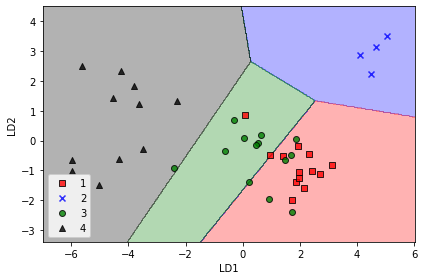

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

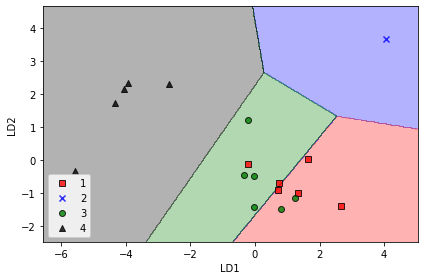

In [ ]:
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()